In [83]:
import paho.mqtt.client as mqtt
import threading
import os
# import motionlocalizer.settings
import json
# import requests
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
import xml.etree.ElementTree
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import time as pythonTimer

my_map = [(0.0, 0.0), (0.0, 5.7), (7.05, 5.7), (7.05, 0.0)]
grid_map = np.zeros((int(my_map[2][0]) * 10, int(my_map[2][1]) * 10))

def on_connect(client, userdata, flags, rc):
    # print("user "+str(userdata))
    # print("client "+str(client))
    # print("Connected with result code "+str(rc))
    client.subscribe("/casiSimulator/#")

def on_message(client, userdata, msg):
    print(msg.topic+" "+str(msg.payload))
    if msg.topic == '/casiSimulator/#':
        print(msg.topic+" "+str(msg.payload))

def on_publish(client, userdata, result):
    # print("Data published :" + str(client) + " " + str(userdata) + str(result) + "\n")
    ParseResult(result)
    pass

def on_subscribed(mosq, obj, mid, granted_qos):
    print("Subscribed mid: " + str(mid) + ", qos: " + str(granted_qos))
    
def start_localizing():
    global grid_map
    # threading.Thread(target=run_localization).start()
    # print("in start_localizing:" + str(np.max(grid_map)))
    grid_map = run_localization()
    return grid_map

def run_localization():
    global grid_map
    # starttime = pythonTimer.time()
    # print("in in run localization:" + str(np.max(grid_map)))
    grid_map = Localizer(pythonTimer.time()).run(event)
    return grid_map
    # pythonTimer.sleep(1.0 - ((pythonTimer.time() - starttime) % 1.0))

def ParseResult(result):            
    event = Event()
    event.sensor = (result.split('/')[3]).split(' ')[0]
    event.data = ((result.split('/')[3]).split(' ')[1]).split(',')[2]
    event.hash = "|hash|"
    event.source = (result.split('/')[3]).split(' ')[0]
    event.timestamp = ((result.split('/')[3]).split(' ')[1]).split(',')[0]
    return event

In [84]:
# Copyright (c) 2017 The Governors of the University of Alberta

class Sensor:
    sensor_type = ""
    sensor_id = ""
    x = float()
    y = float()
    z = float()
    sensing_area = ""

    def __str__(self):
        return 'type: %s,\n id: %s,\n x: %s,\n y: %s\n'%(self.sensor_type, self.sensor_id, self.x, self.y)

    def Initialize(self, element):
        self.x = (str(element.find('point').find('xcoord').text))
        self.y = (str(element.find('point').find('ycoord').text))
        self.sensor_id = (str(element.find('id').text))
        self.sensor_type = (str(element.find('type').text))
        
        if self.sensor_type == 'RFID_Reader':
            self.sensing_area = (str(element.find('arcSize').text))
            
        elif self.sensor_type == 'MotionSensorBinary':
            self.sensing_area = (str(element.find('radius').text))
            
        elif self.sensor_type == 'MotionSensorAnalog':
            self.sensing_area = (str(element.find('radius').text))
            
        elif self.sensor_type == 'PressureSensorAnalog':
            self.sensing_area = (str(element.find('radius').text))
        
            
        return 0

class Event:
    source = ""
    timestamp = float()
    sensor = Sensor.sensor_id
    data = int()
    hash = ""

    def __str__(self):
        return 'time: %s --> sensor: <%s>", data: %s' % (
        str(self.timestamp), str(self.sensor), str(self.data))


class GridMap:
    map = ""

In [85]:
##############################
### PARSE SIMULATION WORLD ###
##############################

root = xml.etree.ElementTree.parse('simulationWorld.xml').getroot()


print(grid_map)

sensors_list = []

for element in root:
    if(element.tag == 'sensors'):
        for sensor in element:
            # print(type(sensor))
            this_sensor = Sensor()
            this_sensor.Initialize(sensor)
            
            
            print(type(this_sensor))
            
            sensors_list.append(this_sensor)
            # print(this_sensor.sensor_type + " " + this_sensor.x + " " + this_sensor.y)
            # sensors_list.append(sensor)
            print(sensors_list[len(sensors_list) - 1])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
<type 'instance'>
type: MotionSensorBinary,
 id: MotionSensorBinary-511.6-343.6,
 x: 480,
 y: 343

<type 'instance'>
type: MotionSensorBinary,
 id: MotionSensorBinary-288.3-495.0,
 x: 288,
 y: 495

<type 'instance'>
type: MotionSensorBinary,
 id: MotionSensorBinary-528.3-577.0,
 x: 528,
 y: 577

<type 'instance'>
type: MotionSensorBinary,
 id: MotionSensorBinary-458.3-794.3,
 x: 458,
 y: 794

<type 'instance'>
type: MotionSensorBinary,
 id: MotionSensorBinary-298.3-703.6,
 x: 298,
 y: 703

<type 'instance'>
type: MotionSensorBinary,
 id: MotionSensorBinary-175.6-605.6,
 x: 175,
 y: 605

<type 'instance'>
type: MotionSensorBinary,
 id: MotionSensorBinary-180.3-259.6,
 x: 180,
 y: 259

<type 'instance'>
type: MotionSensorBinary,
 id: MotionSensorBinary-91.6-157.6,
 x: 91,
 y: 157

<type 'instance'>
type: MotionSensorBinary,
 id: Motio

In [102]:
##########################
### LOCALIZATION CLASS ###
##########################

# Copyright (c) 2017 The Governors of the University of Alberta

class Localizer(threading.Thread):
    to_be_localized_queue = []
    localizer_lock = threading.Lock()
    this_grid_map = []
    
    
    def __init__(self, time):
        self.time = time

    def run(self, event):
        global grid_map
        Localizer.to_be_localized_queue.append(self.time)
        with Localizer.localizer_lock:
            while len(Localizer.to_be_localized_queue) > 0:
                timestamp = Localizer.to_be_localized_queue[0]
                Localizer.to_be_localized_queue = Localizer.to_be_localized_queue[1:]
                grid_map = self.localize(timestamp, event)

        return grid_map
    
    def localizer_confidence(self):
        return 0.9

    def get_event_period(self):
        return 1.0
    
    def localize(self, time, event):
        global grid_map
        fired_sensors = []
        fired_sensors = self.FindFiredSensor(event)
        if len(fired_sensors) == 0:
            return
        
        counter = 0
        for i in range(len(grid_map[:,1])):
            for j in range(len(grid_map[1,:])):
                for sensor in fired_sensors:
                    my_sensor = Sensor()
                    my_sensor = sensor
                    r = my_sensor.sensing_area
                    x = my_sensor.x
                    y = my_sensor.y

                    circ = Circle((int(int(x)/10), int(int(y)/10)), int(int(r)/10))
                    
                    if (circ.contains_point([i, j])):
                        grid_map[i][j] += 1

        sumofpoints = sum(sum(grid_map))
        print("SUm of points is: " + str(sumofpoints))
        
        if (sumofpoints == 0):
            print("nooooooooooooooooooo")
        else:
            grid_map = np.true_divide(grid_map, sumofpoints)
          
        print("the max in final stage is: " + str(np.max(grid_map)))
        
        #grid_map = self.NormalizeGrid()
        
        m = np.min(grid_map)
        M = np.max(grid_map)
        
        m1 = np.min(grid_map[np.nonzero(grid_map)])
        M1 = np.max(grid_map[np.nonzero(grid_map)])
        
        print("Value:", m1)
        print("Value:", M1)
        
        for i in range(len(grid_map[:,1])):
            for j in range(len(grid_map[1,:])):
                grid_map[i][j] = (grid_map[i][j] - m) / (M - m)
        
        
        
        plt.imshow(grid_map, cmap='hot', interpolation='nearest')
        plt.show()
        return grid_map
        
        
    def NormalizeGrid(self):
        print("herereeeee")
        global grid_map
        
        ####
        
        return grid_map
        
    def FindFiredSensor(self, event):
        fired_sensors2 = []
        firedsensor = event.sensor
        for i in range(len(sensors_list)):
            current_sensor = Sensor()
            current_sensor = sensors_list[i]
            if current_sensor.sensor_id == firedsensor:
                fired_sensors2.append(current_sensor)
        
        return fired_sensors2
    
    def extract_fired_sensors(self, start, end):
        sensors = sensors_list
        fired_sensors = []
        for s in sensors:
            if Event.objects.filter(timestamp__gt=start, timestamp__lt=end, sensor=s).exists():
                fired_sensors.append(s)
                continue
            if Event.objects.filter(sensor=s).exists():
                last_event = Event.objects.filter(sensor=s).latest(field_name='timestamp')
                if int(last_event.data) == 1:
                    # print('latest is 1')
                    # print(s)
                    fired_sensors.append(s)

        return fired_sensors


first input
SUm of points is: 28.0
the max in final stage is: 0.03571428571428571
('Value:', 0.03571428571428571)
('Value:', 0.03571428571428571)


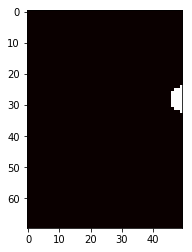

TypeError: 'NoneType' object has no attribute '__getitem__'

In [103]:
#temporary:
my_map = [(0.0, 0.0), (0.0, 5.7), (7.05, 5.7), (7.05, 0.0)]
grid_map = np.zeros((int(my_map[2][0]) * 10, int(my_map[2][1]) * 10))



# print(np.max(grid_map))
print("first input")
result = "casiSimulator/sensor_readings/MotionSensorBinary/MotionSensorBinary-288.3-495.0 1538687434000,MotionSensorBinary,MotionSensorBinary-288.3-495.0,TRUE,TRUE1"
event = ParseResult(result)
grid_map = start_localizing()
print(np.max(grid_map[np.nonzero(grid_map)]))
print(np.min(grid_map[np.nonzero(grid_map)]))

print('---------------------------')

# print(np.max(grid_map))
print("second input")
result1 = "casiSimulator/sensor_readings/MotionSensorBinary/MotionSensorBinary-511.6-343.6 1538687449000,MotionSensorBinary,MotionSensorBinary-511.6-343.6,TRUE,TRUE1"
event = ParseResult(result1)
grid_map = start_localizing()
print(np.max(grid_map[np.nonzero(grid_map)]))
print(np.min(grid_map[np.nonzero(grid_map)]))




In [63]:
print(np.max(grid_map))
# sumofpoints = sum(sum(grid_map))
# normed_grid_map = np.true_divide(grid_map, counter)

0.02040816326530612


In [63]:
a = grid_map
print(a)
# a = [4, 8, 0, 1, 5]

m = np.min(a[np.nonzero(a)])
M = np.max(a[np.nonzero(a)])

print("Value:", m)
print("Value:", M)
# Position: 3
# Value: 1

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
('Value:', 1.0)
('Value:', 1.0)


In [ ]:
port = 1883
host = "localhost"
keepalive = 60
broker_topic = "#"  #All topics have to be read



client = mqtt.Client()
client.on_connect = on_connect
client.on_message = on_message
client.on_publish = on_publish
client.on_subscribed = on_subscribed

client.connect(host, port, 60)
client.subscribe(broker_topic, 0)

client.loop_start()
